In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from pandas import concat
import numpy as np
from math import sqrt

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox

import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from matplotlib import colors

In [3]:
df = pd.read_csv("Finland.csv")
df = df.iloc[:, 3:]
df.set_index("Datetime (Local)", inplace=True)

df = df.rename(columns={
    df.columns[0]: "Price"        
})

df

,Price
Datetime (Local),
2015-01-01 02:00:00,23.37
2015-01-01 03:00:00,19.33
2015-01-01 04:00:00,17.66
2015-01-01 05:00:00,17.53
2015-01-01 06:00:00,18.07
...,...
2025-04-03 19:00:00,-2.12
2025-04-03 20:00:00,-2.02
2025-04-03 21:00:00,-2.03


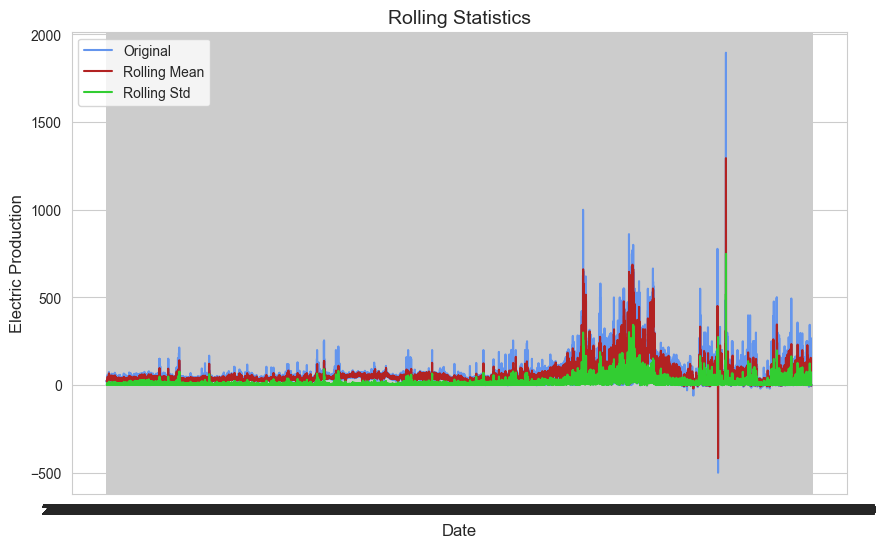

In [4]:
rolling_mean = df.rolling(window=12).mean()
rolling_std = df.rolling(window=12).std()
plt.figure(figsize = (10,6))
plt.plot(df, color='cornflowerblue', label='Original')
plt.plot(rolling_mean, color='firebrick', label='Rolling Mean')
plt.plot(rolling_std, color='limegreen', label='Rolling Std')
plt.xlabel('Date', size = 12)
plt.ylabel('Electricity Price', size  = 12)
plt.legend(loc = 'upper left')
plt.title('Rolling Statistics', size = 14)
plt.show()

Checking Stationarity 


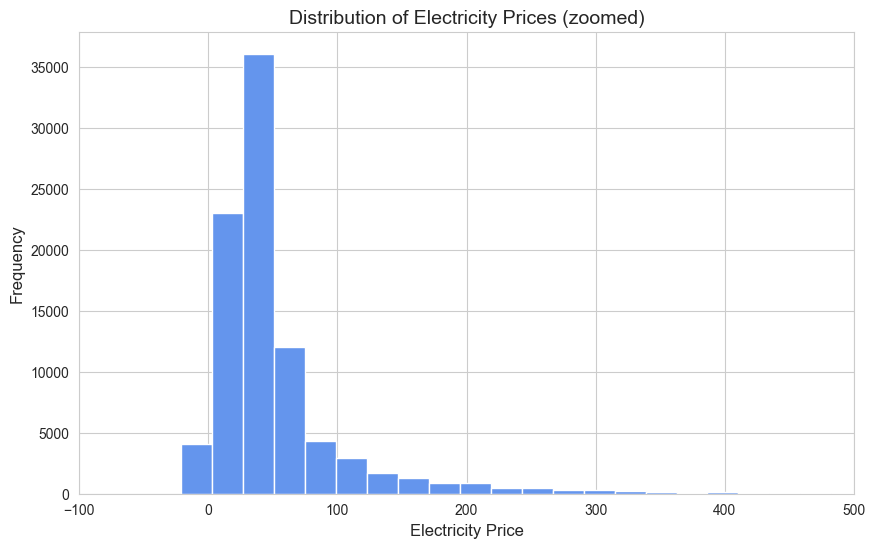

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(df['Price'], bins=100, color='cornflowerblue')
plt.xlim(-100, 500)  
plt.xlabel('Electricity Price', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Distribution of Electricity Prices (zoomed)', size=14)
plt.show()


In [8]:
midpoint = len(df) // 2 

value_1 = df.iloc[0:midpoint]
value_2 = df.iloc[midpoint:]

print("Mean of first half:\n", value_1.mean())
print("\nMean of second half:\n", value_2.mean())


Mean of first half:
 Price    36.937079
dtype: float64

Mean of second half:
 Price    71.236696
dtype: float64


In [9]:
print("Variance of first half:\n", value_1.var())
print("\Variance of second half:\n", value_2.var())

Variance of first half:
 Price    235.151649
dtype: float64
\Variance of second half:
 Price    8063.252977
dtype: float64


We can see quite a big variance here

Augmented Dickey-Fuller Test

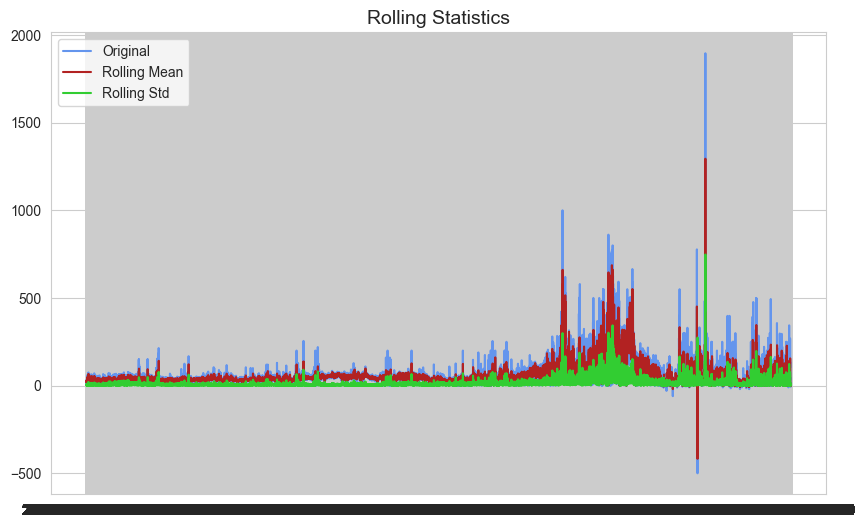

ADF Statistic: -13.785
p-value: 0.0
##################################
Critical Values:
1%: -3.43
5%: -2.862
10%: -2.567
##################################
ADF < Critical Values
Reject null hypothesis, time series is stationary.


In [10]:
def adfuller_test(ts, window = 12):
    
    movingAverage = ts.rolling(window).mean()
    movingSTD = ts.rolling(window).std()
    
    plt.figure(figsize = (10,6))
    orig = plt.plot(ts, color='cornflowerblue',
                    label='Original')
    mean = plt.plot(movingAverage, color='firebrick',
                    label='Rolling Mean')
    std = plt.plot(movingSTD, color='limegreen',
                   label='Rolling Std')
    plt.legend(loc = 'upper left')
    plt.title('Rolling Statistics', size = 14)
    plt.show(block=False)
    
    adf = adfuller(ts, autolag='AIC')
    
    print('ADF Statistic: {}'.format(round(adf[0],3)))
    print('p-value: {}'.format(round(adf[1],3)))
    print("##################################")  
    print('Critical Values:')
    
    for key, ts in adf[4].items():
         print('{}: {}'.format(key, round(ts,3)))
    print("##################################")
    
    if adf[0] > adf[4]["5%"]:
        print("ADF > Critical Values")
        print ("Failed to reject null hypothesis, time series is non-stationary.")
    else:
        print("ADF < Critical Values")
        print ("Reject null hypothesis, time series is stationary.")
        
adfuller_test(df, window = 12)

In [17]:
q_low = df['Price'].quantile(0.01)
q_high = df['Price'].quantile(0.99)

df = df[(df['Price'] >= q_low) & (df['Price'] <= q_high)]

print(len(df))


81274


,Price
Datetime (Local),
2015-01-01 02:00:00,23.37
2015-01-01 03:00:00,19.33
2015-01-01 04:00:00,17.66
2015-01-01 05:00:00,17.53
2015-01-01 06:00:00,18.07
...,...
2025-04-01 18:00:00,20.00
2025-04-01 19:00:00,13.02
2025-04-02 18:00:00,7.13


In [45]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['Price_norm'] = scaler.fit_transform(df[['Price']])


series = df['Price_norm']

split_idx = int(len(series) * 0.8)
train_series = series[:split_idx]
test_series = series[split_idx:]

model = ARIMA(train_series, order=(2, 1, 2))
model_fit = model.fit()

predictions = model_fit.predict(start=split_idx, end=split_idx + len(test_series) - 1)

mse = mean_squared_error(test_series, predictions)
print("ARIMA MSE:", round(mse, 4))


/Users/ethanbareille/miniconda3/envs/ml_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ethanbareille/miniconda3/envs/ml_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ethanbareille/miniconda3/envs/ml_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ethanbareille/miniconda3/envs/ml_env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary startin

ARIMA MSE: 0.1147


/Users/ethanbareille/miniconda3/envs/ml_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/ethanbareille/miniconda3/envs/ml_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [46]:
predictions = model_fit.predict(
    start=len(train_series), 
    end=len(train_series) + len(test_series) - 1
)


/Users/ethanbareille/miniconda3/envs/ml_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/ethanbareille/miniconda3/envs/ml_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


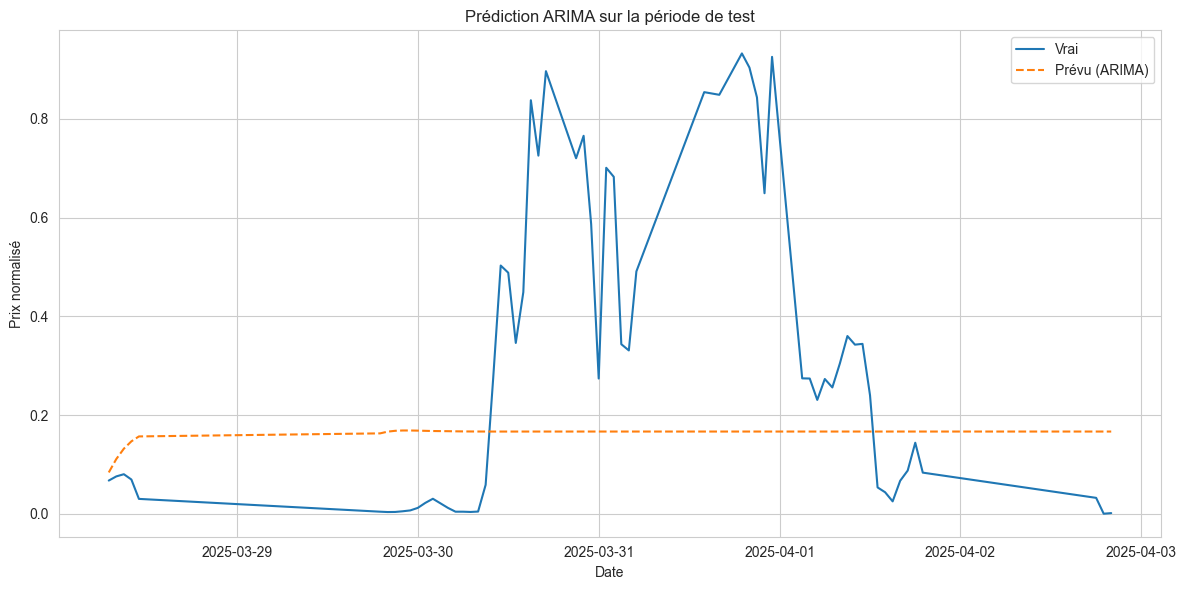

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(test_series.index, test_series.values, label='Vrai')
plt.plot(test_series.index, predictions, label='Prévu (ARIMA)', linestyle='--')
plt.title("Prédiction ARIMA sur la période de test")
plt.xlabel("Date")
plt.ylabel("Prix normalisé")
plt.legend()
plt.tight_layout()
plt.show()


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error

# Chargement des données (supposons déjà dans df avec datetime index et colonne 'Price')
df = df.copy()
df.index = pd.to_datetime(df.index)
df = df.sort_index()

# Supprimer les valeurs aberrantes extrêmes (au-delà de 3 écarts-types)
z_scores = (df["Price"] - df["Price"].mean()) / df["Price"].std()
df = df[(z_scores > -3) & (z_scores < 3)]

# Découpage train/test (80/20)
split_idx = int(len(df) * 0.95)
train_series = df['Price'].iloc[:split_idx]
test_series = df['Price'].iloc[split_idx:]

# Modèle ARIMA automatique (avec AIC comme critère)
model = auto_arima(
    train_series,
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',
    trace=True
)

# Prédiction sur la période de test
n_test = len(test_series)
forecast = model.predict(n_periods=n_test)

# Évaluation
mse = mean_squared_error(test_series, forecast)
rmse = np.sqrt(mse)
print(f"\n✅ ARIMA amélioré — RMSE: {rmse:.2f}")

# Visualisation
plt.figure(figsize=(12, 6))
plt.plot(test_series.index, test_series.values, label="Vrai", color="steelblue")
plt.plot(test_series.index, forecast, label="Prévu (ARIMA)", color="orangered", linestyle="--")
plt.title("Prédiction ARIMA améliorée sur la période de test")
plt.xlabel("Date")
plt.ylabel("Prix (€)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/Users/ethanbareille/miniconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ethanbareille/miniconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ethanbareille/miniconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ethanbareille/miniconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ethanbareille/miniconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/d

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=523472.873, Time=26.95 sec


/Users/ethanbareille/miniconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=531261.184, Time=0.54 sec


/Users/ethanbareille/miniconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=529706.776, Time=0.61 sec


/Users/ethanbareille/miniconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=529558.458, Time=2.88 sec


/Users/ethanbareille/miniconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0]             : AIC=531259.184, Time=0.30 sec


/Users/ethanbareille/miniconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=523995.648, Time=20.86 sec


/Users/ethanbareille/miniconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=523642.627, Time=13.19 sec


/Users/ethanbareille/miniconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


KeyboardInterrupt: 